<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab06_tree-methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6 - Tree-based Methods

### Author: Szymon Nowakowski


# Introduction
-------------------

In today's class, we will explore **Classification and Regression Trees (CART)** and the **Random Forest** algorithm, both of which represent **tree-based methods** in machine learning. **CART** serves as a foundational algorithm capable of handling both **classification** and **regression** tasks. It works by recursively partitioning the data based on the most informative features, resulting in a simple yet powerful binary decision tree. Using measures like **Gini impurity** for classification and **mean squared error** for regression, **CART** selects the best splits to optimize predictive accuracy.

While individual decision trees are easy to interpret, they can suffer from **overfitting**, limiting their generalization to new data. This challenge is effectively addressed by **Random Forest**, an **ensemble method** that constructs multiple decision trees on random subsets of the data and aggregates their predictions. By averaging results in regression tasks or using majority voting in classification, **Random Forest** significantly improves accuracy and robustness while reducing overfitting.

Both **CART** and **Random Forest** are considered **off-the-shelf** methods, meaning they can be applied directly to a wide range of problems with minimal tuning, making them go-to solutions for many real-world machine learning tasks. Today, we will implement these algorithms, apply them to datasets, and evaluate their performance to better understand their practical applications.

# CART: Detailed Explanation
----------------------------

## The Split into Regions in Decision Trees

In both **classification** and **regression trees**, the data space is recursively partitioned into rectangular regions based on feature values. At each node of the tree, the algorithm selects a **feature** and a **threshold** that best splits the data into two subsets. This process continues recursively, resulting in a hierarchical partitioning of the feature space.

- Each split corresponds to a decision rule, like $X_j < t$, where $X_j$ is a feature and $t$ is the threshold.
- The data points that satisfy the rule go to the left branch; the rest go to the right.
- The process continues until a stopping criterion is met (e.g., maximum depth, minimum number of samples, or impurity threshold).

The end result is a division of the space into **non-overlapping regions** $R_1, R_2, \dots, R_M$, where each region corresponds to a terminal (leaf) node in the tree.




## How the Regression Tree Predicts a New Value

In a **regression tree**, the prediction for a new observation is based on the **mean** of the target values in the region where the observation falls.

- When a new data point is passed through the tree, it follows the decision rules from the root to a specific leaf node.
- The predicted value is the **average** of the training data points within that leaf's region.

**Mathematically:**

If a region $R_m$ contains data points $\{y_i\}_{i=1}^{N_m}$, the prediction $\hat{y}$ for any $x \in R_m$ is:

$$
\hat{y} = \frac{1}{N_m} \sum_{i: x_i \in R_m} y_i
$$

## How the Regression Tree Builds the Region Partitioning

The goal in regression is to minimize the **sum of squared residuals (SSR)** within each region. At each split, the algorithm selects:

- The **feature** $X_j$ to split on.
- The corresponding **threshold** $t$ for that feature.

**The selection process involves both $X_j$ (the feature) and $t$ (the split point).**

The algorithm proceeds as follows:

1. **For each feature** $X_j$:
   - Consider all possible thresholds $t$ (often midpoints between sorted unique values).
   - Evaluate the SSR for each possible split.

2. **Select the feature $X_j^*$ and threshold $t^*$** that minimize the total SSR:

  $$
  (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i: x_i \in R_m} (y_i - \bar{y}_{R_m})^2
  $$


  Where:

  - $R_m$ is a region (leaf node) defined by the splits.
  - $\bar{y}_{R_m}$ is the mean target value in region $R_m$.

  This process is repeated recursively for each new subset until a stopping criterion is met.

## Question

Do we really need to consider all possible values $t$ for the split? How can we attempt to optimize the selection process?

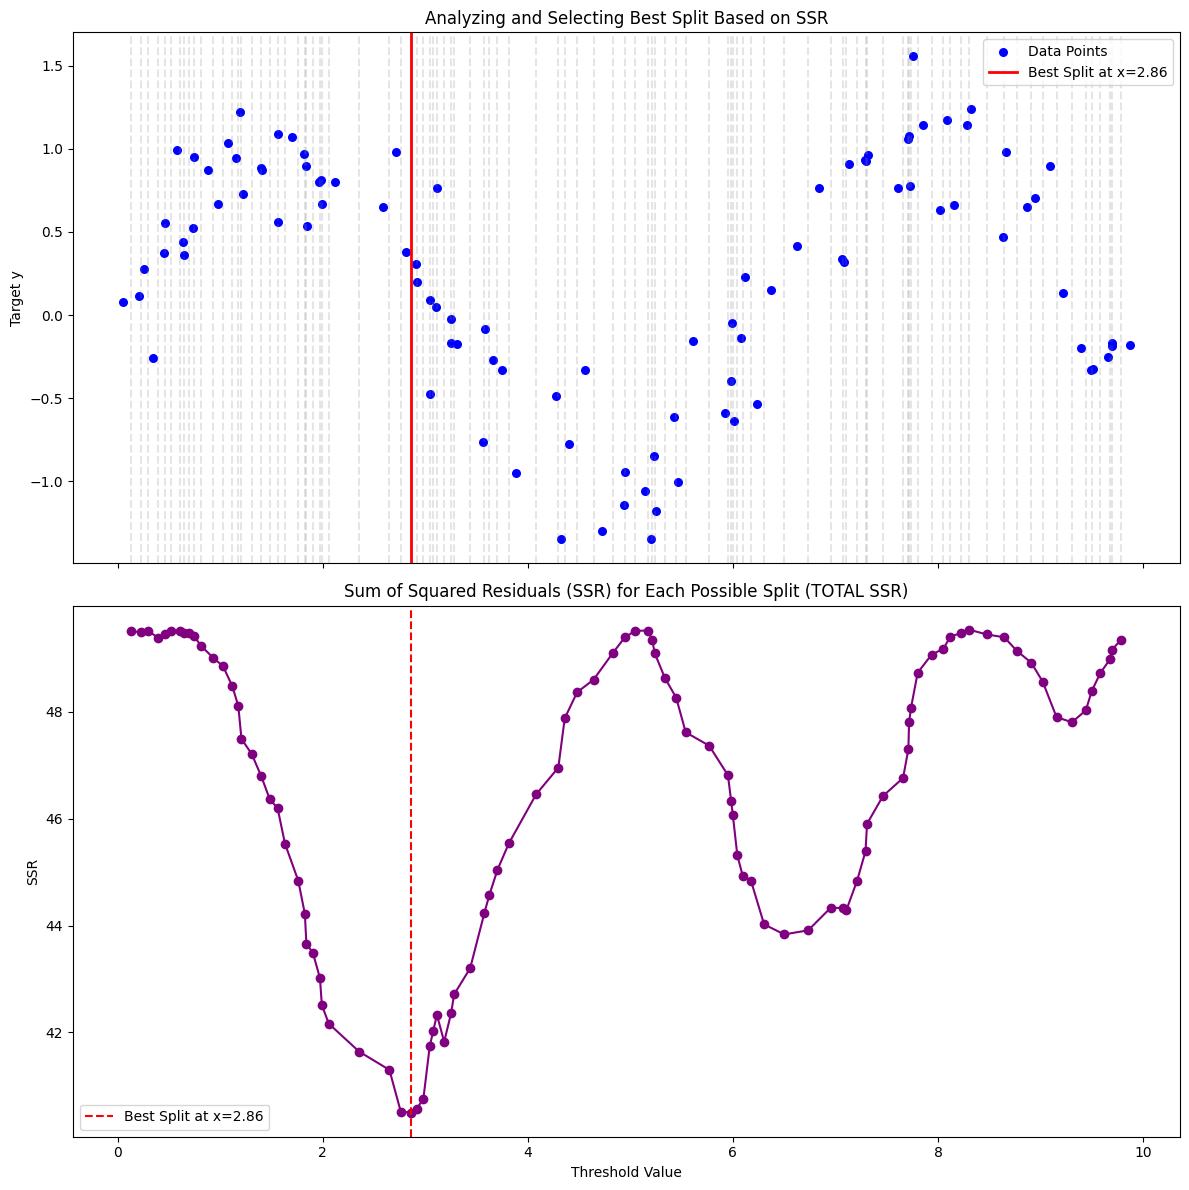

Best split at x = 2.86 with TOTAL SSR = 40.50


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)
X = np.sort(np.random.rand(100) * 10)  # 1D array for simplicity
y = np.sin(X) + np.random.normal(0, 0.3, size=X.shape[0])  # Noisy sine wave

# Step 2: Analyze possible splits and compute SSR
def compute_ssr(y):
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

best_ssr = float('inf')
best_split = None
ssr_list = []

# Consider splits between adjacent sorted X values
for i in range(1, len(X)):
    threshold = (X[i - 1] + X[i]) / 2

    # Split data using boolean masks
    left_mask = X < threshold
    right_mask = X >= threshold

    # Calculate SSR for each region
    ssr_left = compute_ssr(y[left_mask])
    ssr_right = compute_ssr(y[right_mask])
    total_ssr = ssr_left + ssr_right

    ssr_list.append((threshold, total_ssr))

    # Keep track of the best split
    if total_ssr < best_ssr:
        best_ssr = total_ssr
        best_split = threshold

# Visualize the data, splits, and the best split along with SSR values
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)  # Two vertically aligned subplots

# First subplot: Original data with split lines
axes[0].scatter(X, y, color='blue', label='Data Points', s=30)

for threshold, ssr in ssr_list:
    axes[0].axvline(x=threshold, color='gray', linestyle='--', alpha=0.2)

axes[0].axvline(x=best_split, color='red', linestyle='-', linewidth=2, label=f'Best Split at x={best_split:.2f}')
axes[0].set_title('Analyzing and Selecting Best Split Based on SSR')
axes[0].set_ylabel('Target y')
axes[0].legend()

# Second subplot: SSR values for each split
thresholds, ssrs = zip(*ssr_list)
axes[1].plot(thresholds, ssrs, marker='o', color='purple')
axes[1].axvline(x=best_split, color='red', linestyle='--', label=f'Best Split at x={best_split:.2f}')
axes[1].set_title('Sum of Squared Residuals (SSR) for Each Possible Split (TOTAL SSR)')
axes[1].set_xlabel('Threshold Value')
axes[1].set_ylabel('SSR')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


print(f"Best split at x = {best_split:.2f} with TOTAL SSR = {best_ssr:.2f}")



## How the Classification Tree Predicts a Class for a New Observation

In a **classification tree**, the prediction for a new observation is based on the **majority class** within the region it falls into.

- The new observation follows the decision rules down the tree until it reaches a leaf node.
- The predicted class is the one with the highest proportion of samples in that leaf.

If region $R_m$ contains samples from classes $C_1, C_2, \dots, C_k$, the predicted class $\hat{C}$ is:

$$
\hat{C} = \arg\max_{c} \, P_c
$$

Where $P_c$ is the proportion of class $c$ in region $R_m$.


## How the Classification Tree Builds the Region Partitioning

In classification, the goal is to minimize impurity in the resulting regions. At each split, the algorithm selects:

- The **feature** $X_j$ to split on.
- The corresponding **threshold** $t$ for that feature.

**The selection process again involves both $X_j$ (the feature) and $t$ (the split point).**

The process is as follows:

1. **For each feature** $X_j$:
   - Consider all possible thresholds $t$.
   - Calculate impurity measures (Gini or Cross-Entropy) for the resulting splits.

2. **Select the feature $X_j^*$ and threshold $t^*$** that result in the **largest decrease in impurity**.

  a) Gini Index

    The **Gini Index** measures the probability of misclassification:

    $$
    G(R_m) = 1 - \sum_{c=1}^{K} p_{mc}^2
    $$

    Where:

    - $p_{mc}$ is the proportion of samples of class $c$ in region $R_m$.

  b) Cross-Entropy (Deviance)

    The **Cross-Entropy** measure is:

    $$
    H(R_m) = - \sum_{c=1}^{K} p_{mc} \log(p_{mc})
    $$

The split that leads to the **greatest reduction in impurity** (using either Gini or Cross-Entropy) is selected.




##Gain Formula

The **Gini Gain** measures the reduction in impurity achieved by a split in a decision tree. It is calculated as follows:

$$
\text{Gain} = \text{Measure(parent)} - \left( \frac{N_L}{N} \cdot \text{Measure}(L) + \frac{N_R}{N} \cdot \text{Measure}(R) \right)
$$

Where:
- $\text{Measure}()$ stands for Gini $\text{G}()$ or Cross-Entropy $\text{H}()$
- $N$ = Total number of samples in the parent node
- $N_L$ = Number of samples in the left (or low) child node
- $N_R$ = Number of samples in the right (or top) child node
- $\text{Measure(parent)}$ measures impurity of the parent node
- $\text{Measure}(L)$ = measures impurity of the left (low) child
- $\text{Measure}(R)$ = measures impurity of the right (top) child

The split that results in the **highest Gain** is typically selected, as it leads to the most significant reduction in impurity.




## Key Points

- The **tree-building process selects both the feature** $X_j$ **and the threshold** $t$ **that optimally split the data** based on the chosen objective (SSR for regression, impurity reduction for classification).
- This process continues recursively, resulting in a tree that partitions the data space into regions with either low variance (for regression) or low impurity (for classification).


** FIRST SPLIT **
 - Parent Gini = 0.5000
 - Best gain = 0.4615
 - Weighted Child Gini = 0.0385
 => Feature 2, Threshold=-0.24


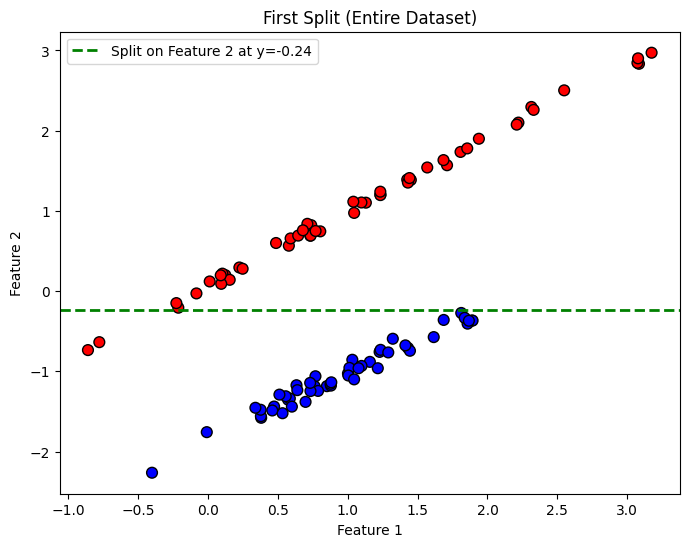

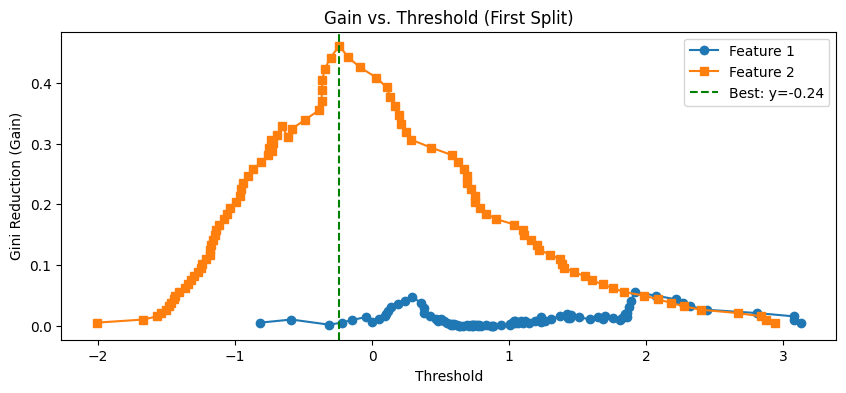

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# -------------------------------------------------------------------
# 1) Generate the 2D Dataset
# -------------------------------------------------------------------
np.random.seed(42)
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=2,
    random_state=42
)

# -------------------------------------------------------------------
# 2) Helper Functions
# -------------------------------------------------------------------
def compute_gini(y_subset):
    """
    Compute Gini impurity for a binary classification:
       Gini = 1 - (p0^2 + p1^2)
    """
    if len(y_subset) == 0:
        return 0.0
    p0 = np.mean(y_subset == 0)
    p1 = 1 - p0
    return 1.0 - (p0**2 + p1**2)

def find_best_split(X_data, y_data):
    """
    Finds the split that MAXIMIZES the 'gain' in Gini, i.e.:
        gain = Gini(parent) - [weighted Gini(children)]

    Returns:
      best_gain   : float   (the maximum reduction in Gini)
      best_split  : (feat_idx, threshold)
      all_splits  : list of (feat_idx, threshold, gain)
    """
    parent_gini = compute_gini(y_data)
    n_total = len(y_data)

    best_gain = -1.0
    best_split = None
    all_splits = []

    n_features = X_data.shape[1]

    for feat_idx in range(n_features):
        # Sort by this feature
        sort_idx = np.argsort(X_data[:, feat_idx])
        X_sorted = X_data[sort_idx]
        y_sorted = y_data[sort_idx]

        # Check thresholds between adjacent points
        for i in range(1, n_total):
            threshold = 0.5 * (X_sorted[i - 1, feat_idx] + X_sorted[i, feat_idx])

            left_mask = (X_data[:, feat_idx] < threshold)
            right_mask = ~left_mask

            gini_left = compute_gini(y_data[left_mask])
            gini_right = compute_gini(y_data[right_mask])

            # Weighted child Gini
            w_child_gini = (gini_left * np.sum(left_mask) +
                            gini_right * np.sum(right_mask)) / n_total

            gain = parent_gini - w_child_gini
            all_splits.append((feat_idx, threshold, gain))

            # Track the best split (max gain)
            if gain > best_gain:
                best_gain = gain
                best_split = (feat_idx, threshold)

    return best_gain, best_split, all_splits

def plot_data_with_split(X_data, y_data, feat_idx, threshold, title="Split"):
    """
    Plot ALL data points, draw a single split line (vertical or horizontal)
    across the entire plane.
    """
    plt.figure(figsize=(8,6))
    colors = ['blue' if c == 0 else 'red' for c in y_data]
    plt.scatter(X_data[:,0], X_data[:,1], c=colors, edgecolor='k', s=60)

    if feat_idx == 0:
        # vertical line
        plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
                    label=f"Split on Feature 1 at x={threshold:.2f}")
    else:
        # horizontal line
        plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2,
                    label=f"Split on Feature 2 at y={threshold:.2f}")

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

def plot_gain_vs_threshold(all_splits, best_feat, best_thresh, title="Gain vs. Threshold"):
    """
    Plot the gain for each threshold in each feature.
    We'll mark the best threshold for the best feature with a vertical line.
    """
    f1_thresholds = [t for (f,t,g) in all_splits if f == 0]
    f1_gains      = [g for (f,t,g) in all_splits if f == 0]
    f2_thresholds = [t for (f,t,g) in all_splits if f == 1]
    f2_gains      = [g for (f,t,g) in all_splits if f == 1]

    plt.figure(figsize=(10,4))
    plt.plot(f1_thresholds, f1_gains, 'o-', label='Feature 1')
    plt.plot(f2_thresholds, f2_gains, 's-', label='Feature 2')

    # Mark the best threshold
    if best_feat == 0:
        plt.axvline(best_thresh, color='green', linestyle='--',
                    label=f"Best: x={best_thresh:.2f}")
    else:
        plt.axvline(best_thresh, color='green', linestyle='--',
                    label=f"Best: y={best_thresh:.2f}")

    plt.title(title)
    plt.xlabel("Threshold")
    plt.ylabel("Gini Reduction (Gain)")
    plt.legend()
    plt.show()

# -------------------------------------------------------------------
# 3) Find & Visualize the FIRST Split
# -------------------------------------------------------------------
first_gain, (first_feat, first_thresh), first_splits = find_best_split(X, y)
parent_gini = compute_gini(y)
weighted_child_gini = parent_gini - first_gain

print("** FIRST SPLIT **")
print(f" - Parent Gini = {parent_gini:.4f}")
print(f" - Best gain = {first_gain:.4f}")
print(f" - Weighted Child Gini = {weighted_child_gini:.4f}")
print(f" => Feature {first_feat+1}, Threshold={first_thresh:.2f}")

# Visualize entire dataset + first split line
plot_data_with_split(X, y, first_feat, first_thresh, title="First Split (Entire Dataset)")

# (Optional) Plot gain vs. threshold curves
plot_gain_vs_threshold(first_splits, first_feat, first_thresh, title="Gain vs. Threshold (First Split)")


** FIRST SPLIT Recap **
 - Feature=2, threshold=-0.24
   -> Low subset size: 52
   -> Top subset size: 48

** Potential SECOND SPLIT in LOW subset **
 - Parent Gini (LOW) = 0.0740
 - Best gain (LOW)   = 0.0740
 - Weighted Child Gini = 0.0000
 => Feature 1, threshold=-0.59

** Potential SECOND SPLIT in TOP subset **
 - Parent Gini (TOP) = 0.0000
 - Best gain (TOP)   = 0.0000
 - Weighted Child Gini = 0.0000
 => Feature 1, threshold=-0.22


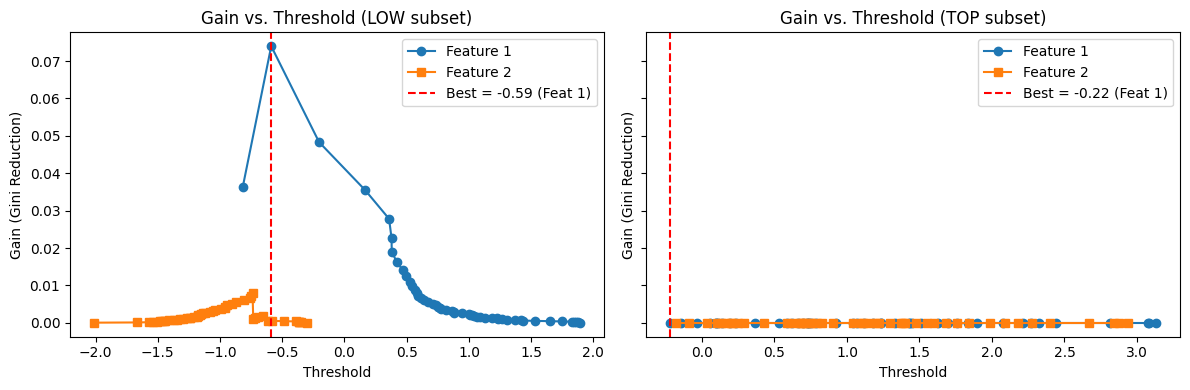


** CHOSEN Second Split = LOW subset **
 - Feature 1
 - Threshold = -0.59
 - Gain = 0.0740


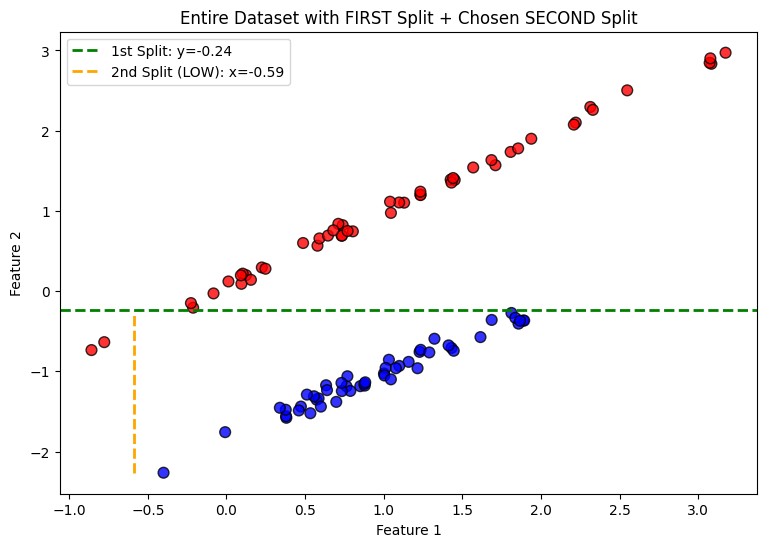

In [18]:
# We assume from Cell 1 we have:
#   X, y
#   first_feat, first_thresh      # The first split
#   find_best_split, compute_gini # Functions
#   plus any plotting utilities

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) Partition the data using the FIRST split
# ----------------------------------------------------
low_mask = (X[:, first_feat] < first_thresh)
top_mask = ~low_mask

X_low, y_low = X[low_mask], y[low_mask]
X_top, y_top = X[top_mask], y[top_mask]

print("** FIRST SPLIT Recap **")
print(f" - Feature={first_feat + 1}, threshold={first_thresh:.2f}")
print(f"   -> Low subset size: {len(y_low)}")
print(f"   -> Top subset size: {len(y_top)}")

# ----------------------------------------------------
# 2) Find a SECOND split in both the LOW and TOP subsets
#    (We measure Gini gain in each subset.)
# ----------------------------------------------------
low_gain, (low_feat, low_thresh), low_splits = find_best_split(X_low, y_low)
top_gain, (top_feat, top_thresh), top_splits = find_best_split(X_top, y_top)

low_parent_gini = compute_gini(y_low)
top_parent_gini = compute_gini(y_top)

print("\n** Potential SECOND SPLIT in LOW subset **")
print(f" - Parent Gini (LOW) = {low_parent_gini:.4f}")
print(f" - Best gain (LOW)   = {low_gain:.4f}")
print(f" - Weighted Child Gini = {low_parent_gini - low_gain:.4f}")
print(f" => Feature {low_feat + 1}, threshold={low_thresh:.2f}")

print("\n** Potential SECOND SPLIT in TOP subset **")
print(f" - Parent Gini (TOP) = {top_parent_gini:.4f}")
print(f" - Best gain (TOP)   = {top_gain:.4f}")
print(f" - Weighted Child Gini = {top_parent_gini - top_gain:.4f}")
print(f" => Feature {top_feat + 1}, threshold={top_thresh:.2f}")

# ----------------------------------------------------
# 3) Side-by-side Gains Plots for LOW and TOP subsets
# ----------------------------------------------------
def plot_gain_vs_threshold_subset(all_splits, best_f, best_t, title):
    """
    Plots the gain vs threshold for the two features in a given subset.
    We'll draw a vertical line at 'best_t' if best_f is that feature.
    """
    f1_thresh = [t for (f, t, g) in all_splits if f == 0]
    f1_gains  = [g for (f, t, g) in all_splits if f == 0]
    f2_thresh = [t for (f, t, g) in all_splits if f == 1]
    f2_gains  = [g for (f, t, g) in all_splits if f == 1]

    plt.plot(f1_thresh, f1_gains, 'o-', label='Feature 1')
    plt.plot(f2_thresh, f2_gains, 's-', label='Feature 2')

    # Mark the best threshold for the best feature
    if best_f == 0:
        plt.axvline(best_t, color='red', linestyle='--',
                    label=f"Best = {best_t:.2f} (Feat 1)")
    else:
        plt.axvline(best_t, color='red', linestyle='--',
                    label=f"Best = {best_t:.2f} (Feat 2)")

    plt.title(title)
    plt.xlabel("Threshold")
    plt.ylabel("Gain (Gini Reduction)")
    plt.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for LOW subset
plt.sca(axes[0])
plot_gain_vs_threshold_subset(
    low_splits, low_feat, low_thresh,
    title="Gain vs. Threshold (LOW subset)"
)

# Plot for TOP subset
plt.sca(axes[1])
plot_gain_vs_threshold_subset(
    top_splits, top_feat, top_thresh,
    title="Gain vs. Threshold (TOP subset)"
)

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 4) Choose the best second split overall
# ----------------------------------------------------
# Compare the best gain in LOW vs. TOP
if low_gain > top_gain:
    chosen_side = "LOW"
    chosen_feat   = low_feat
    chosen_thresh = low_thresh
    chosen_gain   = low_gain
else:
    chosen_side = "TOP"
    chosen_feat   = top_feat
    chosen_thresh = top_thresh
    chosen_gain   = top_gain

print(f"\n** CHOSEN Second Split = {chosen_side} subset **")
print(f" - Feature {chosen_feat + 1}")
print(f" - Threshold = {chosen_thresh:.2f}")
print(f" - Gain = {chosen_gain:.4f}")

# ----------------------------------------------------
# 5) Visualize the ENTIRE dataset again with
#    (a) First split across entire plane
#    (b) ONLY the chosen second split line
# ----------------------------------------------------
plt.figure(figsize=(9,6))
colors = ["blue" if lbl == 0 else "red" for lbl in y]
plt.scatter(X[:,0], X[:,1], c=colors, edgecolor='k', s=60, alpha=0.8)

# (a) First split line across entire plane
if first_feat == 0:
    # vertical
    plt.axvline(first_thresh, color='green', linestyle='--', linewidth=2,
                label=f"1st Split: x={first_thresh:.2f}")
else:
    # horizontal
    plt.axhline(first_thresh, color='green', linestyle='--', linewidth=2,
                label=f"1st Split: y={first_thresh:.2f}")

# (b) The chosen second split line in its bounding box only
if chosen_side == "LOW":
    region_X, region_y = X_low, y_low
else:
    region_X, region_y = X_top, y_top

x_min, x_max = region_X[:,0].min(), region_X[:,0].max()
y_min, y_max = region_X[:,1].min(), region_X[:,1].max()

if chosen_feat == 0:
    # vertical line restricted to region's bounding box
    plt.plot(
        [chosen_thresh, chosen_thresh],
        [y_min, y_max],
        color='orange', linestyle='--', linewidth=2,
        label=f"2nd Split ({chosen_side}): x={chosen_thresh:.2f}"
    )
else:
    # horizontal line
    plt.plot(
        [x_min, x_max],
        [chosen_thresh, chosen_thresh],
        color='orange', linestyle='--', linewidth=2,
        label=f"2nd Split ({chosen_side}): y={chosen_thresh:.2f}"
    )

plt.title("Entire Dataset with FIRST Split + Chosen SECOND Split")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


# Building CART on a Real Dataset
--------------------------------

## The California Housing Dataset

The California Housing dataset is a standard real-world dataset included in `sklearn.datasets`. It features 20,640 instances and 8 numerical features. It is commonly used in regression tasks to predict housing prices based on various socio-economic and geographical factors. Below is a detailed description:

1. **Target Variable**  
The target variable is **MedianHouseValue**, which represents the median house price (in $100,000s) for a given California district.

2. **Predictors**  
The dataset includes 8 numerical features that describe various characteristics of California districts:

    **MedInc**: Median income of the district (scaled).  
    **HouseAge**: Median age of the district's houses.  
    **AveRooms**: Average number of rooms per household.  
    **AveBedrms**: Average number of bedrooms per household.  
    **Population**: Total population in the district.  
    **AveOccup**: Average number of occupants per household.  
    **Latitude**: Geographical latitude of the district.  
    **Longitude**: Geographical longitude of the district.

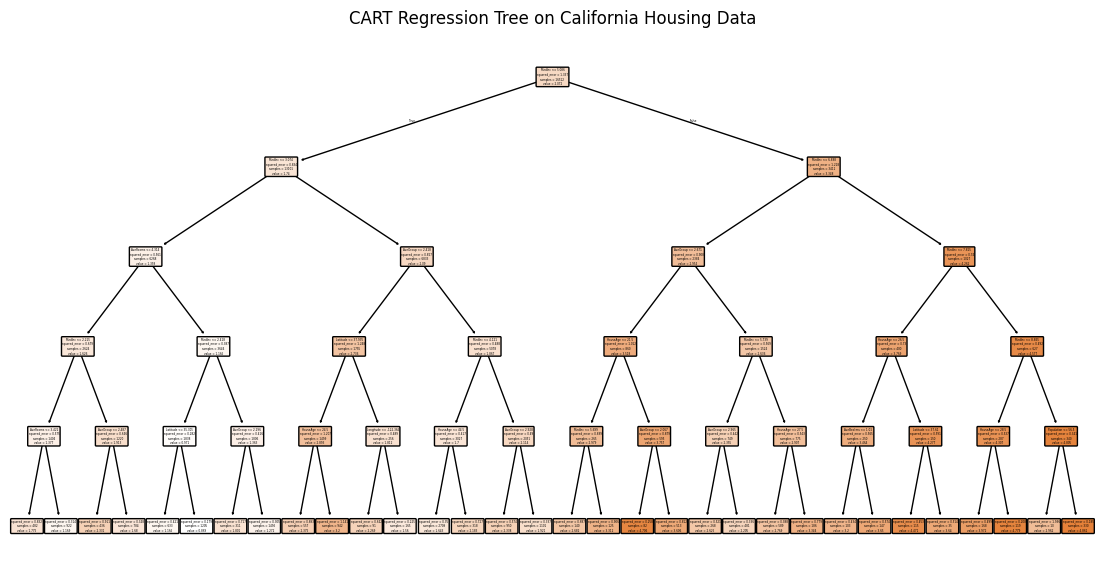

Training MSE: 0.4843, RMSE: 0.6959, R²: 0.6377
Testing MSE: 0.5245, RMSE: 0.7242, R²: 0.5997


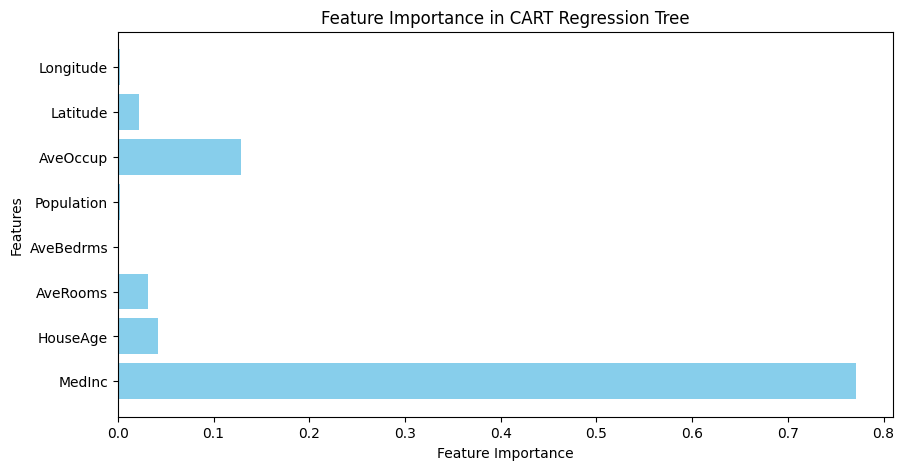

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target  # Features and target

# Step 2: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a CART regression tree
cart_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)  # Limit depth to avoid overfitting
cart_regressor.fit(X_train, y_train)

# Step 4: Visualize the Decision Tree
plt.figure(figsize=(14, 7))
plot_tree(cart_regressor, feature_names=data.feature_names, filled=True, rounded=True)

plt.title("CART Regression Tree on California Housing Data")
plt.show()

# Step 5: Make predictions
y_train_pred = cart_regressor.predict(X_train)
y_test_pred = cart_regressor.predict(X_test)

# Step 6: Evaluate model performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.4f}, RMSE: {(train_mse**0.5):.4f}, R²: {train_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}, RMSE: {(test_mse**0.5):.4f}, R²: {test_r2:.4f}")



## Improving Readability

The full tree is not quite readable. To improve readability, restrict the max depth of the tree

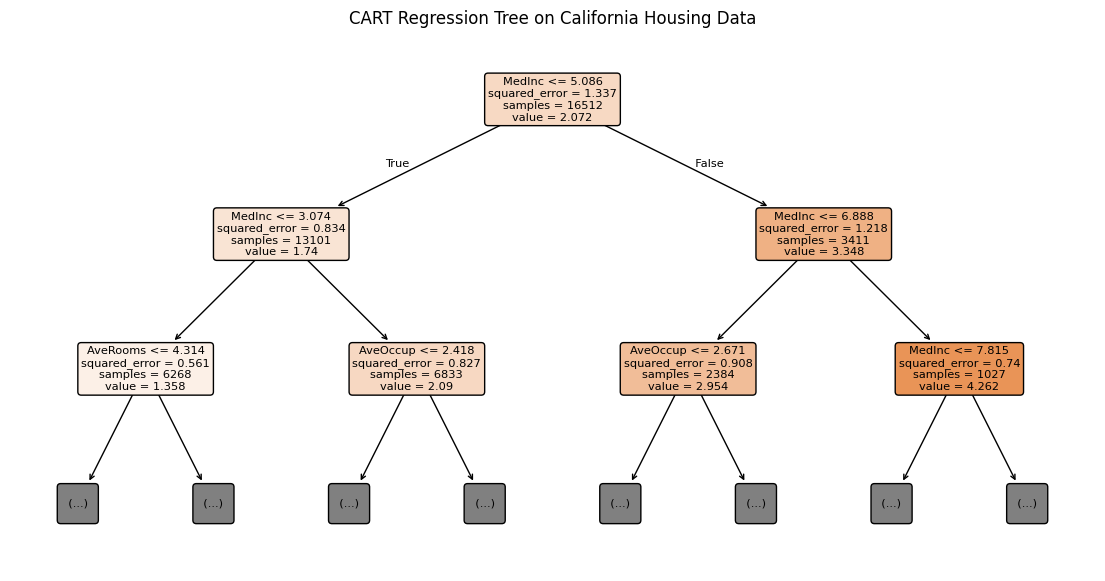

In [6]:
# Step 4: Visualize the Decision Tree
plt.figure(figsize=(14, 7))
plot_tree(cart_regressor, feature_names=data.feature_names, filled=True, rounded=True, max_depth=2)

plt.title("CART Regression Tree on California Housing Data")
plt.show()


## Feature Importance Analysis

For regression, feature importance is based on the reduction in RSS (Residual Sum of Squares) in this feature throughout the tree:

$$
I(X_j) = \sum_{\text{splits on } X_j} (RSS_{\text{parent}} - RSS_L - RSS_R)
$$

where $RSS$ is the Residual Sum of Squares.

For classification, similarly, instead of RSS Gini index  or Cross Entropy is used.

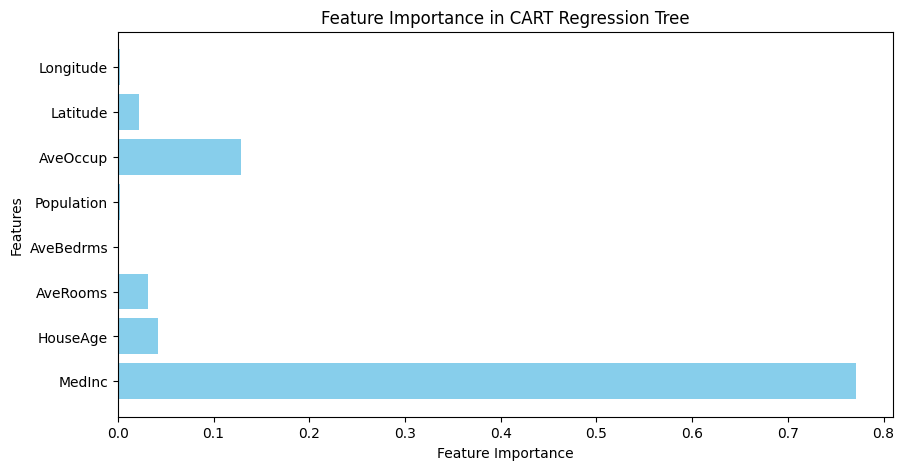

In [8]:

# Feature Importance Analysis
feature_importance = cart_regressor.feature_importances_
plt.figure(figsize=(10, 5))
plt.barh(data.feature_names, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CART Regression Tree")
plt.show()

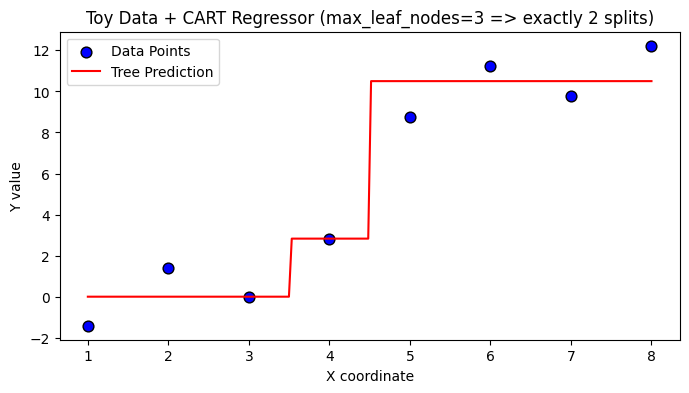

** Decision Tree (Textual) **
|--- x <= 4.50
|   |--- x <= 3.50
|   |   |--- value: [0.00]
|   |--- x >  3.50
|   |   |--- value: [2.83]
|--- x >  4.50
|   |--- value: [10.50]



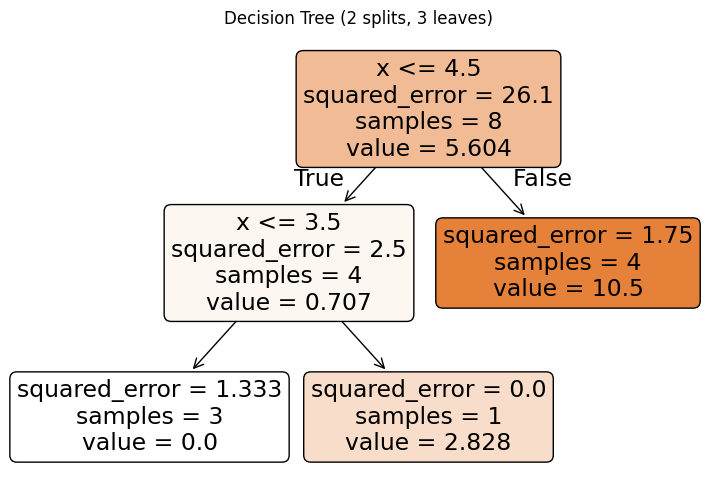

In [7]:
# -------------------------------------------------------------------
# ORIGINAL CODE (must remain unchanged, including the comments)
# -------------------------------------------------------------------
# First set of 4 points - RSS = 10, division RSS = (0 + 4; 4 + 4), gains = (6, 2)
y_group1 = np.array([-1.4142, 1.4142, 0.0000, 2.8284])

# Second set of 4 points, shifted by +10 - RSS = 7, division RSS = (0 + 3.033; 3 + 3) , gains = (3.06, 1)
y_group2 = np.array([-1.2247, 1.2247, -0.2247, 2.2247]) + 10

# Combine both groups into one dataset
y_values_8 = np.concatenate((y_group1, y_group2))
# -------------------------------------------------------------------
# END OF ORIGINAL CODE
# -------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text

# 1) Create x-coordinates for the 8 points: 1, 2, 3, 4, 5, 6, 7, 8
x_values_8 = np.arange(1, len(y_values_8) + 1).reshape(-1, 1)

# 2) Fit a CART regressor with exactly 2 splits => set max_leaf_nodes=3
#    (3 leaves => 2 internal splits in total)
reg = DecisionTreeRegressor(
    criterion='squared_error',
    max_leaf_nodes=3,  # ensures at most 3 terminal nodes => 2 splits
    random_state=42
)
reg.fit(x_values_8, y_values_8)

# 3) Visualize the data points + the piecewise-constant prediction
plt.figure(figsize=(8, 4))
plt.scatter(x_values_8, y_values_8, color='blue', edgecolor='k', s=60, label='Data Points')

# A smooth x-grid for plotting the prediction
x_grid = np.linspace(1, 8, 200).reshape(-1, 1)
y_pred = reg.predict(x_grid)
plt.plot(x_grid, y_pred, color='red', label='Tree Prediction')

plt.title("Toy Data + CART Regressor (max_leaf_nodes=3 => exactly 2 splits)")
plt.xlabel("X coordinate")
plt.ylabel("Y value")
plt.legend()
plt.show()

# 4) Print a textual description of the resulting tree
tree_text = export_text(reg, feature_names=['x'])
print("** Decision Tree (Textual) **")
print(tree_text)

# 5) Plot the tree structure
plt.figure(figsize=(9, 6))
plot_tree(reg, feature_names=['x'], filled=True, rounded=True)
plt.title("Decision Tree (2 splits, 3 leaves)")
plt.show()
